# How does S3 access scale? 

We can measure how our S3 performance varies as a function of the number of simultaneous workers. We follow the example from `s3_benchmark.ipynb`, see that notebook for more details

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import cPickle as pickle
import seaborn as sns
sns.set_style('whitegrid')
import os
from glob2 import glob
import matplotlib.patches as mpatches


Populating the interactive namespace from numpy and matplotlib


We use the [ruffus pipeline manager](http://www.ruffus.org.uk/) to run a large number of jobs at varying scales. Each one generates a separate pickle file, which we will later load in. Note that running this many jobs with varying initial conditions can take a long time.

run the command
```
python run_many_experiments.py
``` 
which will run sequentially vary the number of workers and save the results into a `s3_microbench.*.pickle` file. We then aggregate all of the data into a series of data frames

In [2]:
# this IO is slightly more complex, in that we do some later joins
# and keep track of unique keys as UUIDs

job_results_df = []
expdf = []
for filename in glob("s3_microbench.*.pickle"):
    benchmark_data = pickle.load(open(filename, 'r'))
    write_results = benchmark_data['write_results']
    read_results = benchmark_data['read_results']
    
    keynames = write_results['keynames']
    
    exp = pd.DataFrame({'keyname' : keynames})
    exp['workers'] = benchmark_data['workers']
    exp['seed'] = benchmark_data['seed']
    exp['mb_per_file'] = benchmark_data['mb_per_file']
    exp['read_start_timestamp'] = benchmark_data['read_start_timestamp']
    exp['write_start_timestamp'] = benchmark_data['write_start_timestamp']
    exp['read_done_timestamp'] = benchmark_data['read_done_timestamp']
    exp['filename'] = filename
    for df, phase in [(read_results, 'read'), (write_results, 'write')]:
        
        results_df = pd.DataFrame(df['run_statuses'])
        invoke_df = pd.DataFrame(df['invoke_statuses'])
        func_results = pd.DataFrame([{'s3_txn_start_timestamp' : a[0], 
                                      's3_txn_end_timestamp' : a[1], 
                                      's3_txn_rate' : a[2]} for a in df['results']])
        
        results_df = pd.concat([results_df, invoke_df, func_results], axis=1)
        Cols = list(results_df.columns)
        for i,item in enumerate(results_df.columns):
            if item in results_df.columns[:i]: Cols[i] = "toDROP"
        results_df.columns = Cols
        results_df = results_df.drop("toDROP",1)
        results_df['keyname'] = keynames
        results_df['phase'] = phase
        results_df['filename'] = filename
        job_results_df.append(results_df)
    expdf.append(exp)
                    
job_results_df = pd.concat(job_results_df)            
expdf = pd.concat(expdf)

In [28]:
# compute rates
expdf['total_mb'] = expdf.workers * expdf.mb_per_file
expdf['read_time'] = expdf.read_done_timestamp - expdf.read_start_timestamp
expdf['write_time'] = expdf.read_start_timestamp - expdf.write_start_timestamp
expdf['read_rate'] = expdf.total_mb / expdf.read_time
expdf['write_rate'] = expdf.total_mb / expdf.write_time


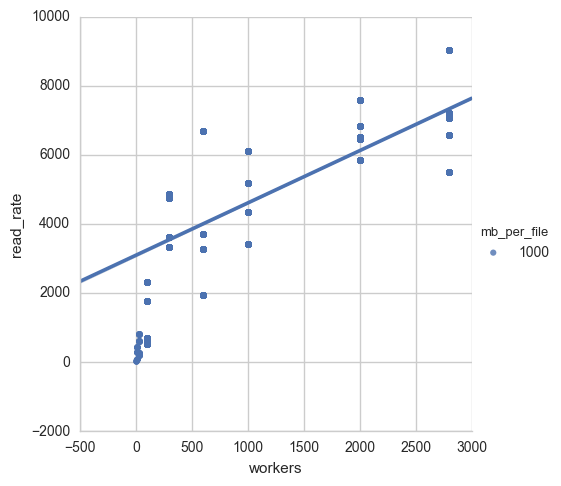

In [4]:
sns.lmplot(x='workers', y='read_rate', data=expdf, hue='mb_per_file')

In [5]:
expdf_top = expdf.groupby('filename').first()

In [6]:
# get distribution of job agg s3 performance
# note that this depends on lambda clocks being correct


max_time = 2000
runtime_bins = np.linspace(0, max_time, max_time, endpoint=False)
filename_hists = {'read' : {}, 
                  'write' : {} }
    
for fname, file_df in job_results_df.groupby([ 'filename']):

    for phase, df in file_df.groupby('phase'):
        time_offset = np.min(df.host_submit_time)

        runtime_rate_hist = np.zeros((len(df), len(runtime_bins)))
        for i in range(len(df)):
            row = df.iloc[i]
            s = row.s3_txn_start_timestamp - time_offset
            e = row.s3_txn_end_timestamp  - time_offset
            a, b = np.searchsorted(runtime_bins, [s, e])
            if b-a > 0:
                runtime_rate_hist[i, a:b] = row.s3_txn_rate
        filename_hists[phase][fname] = runtime_rate_hist


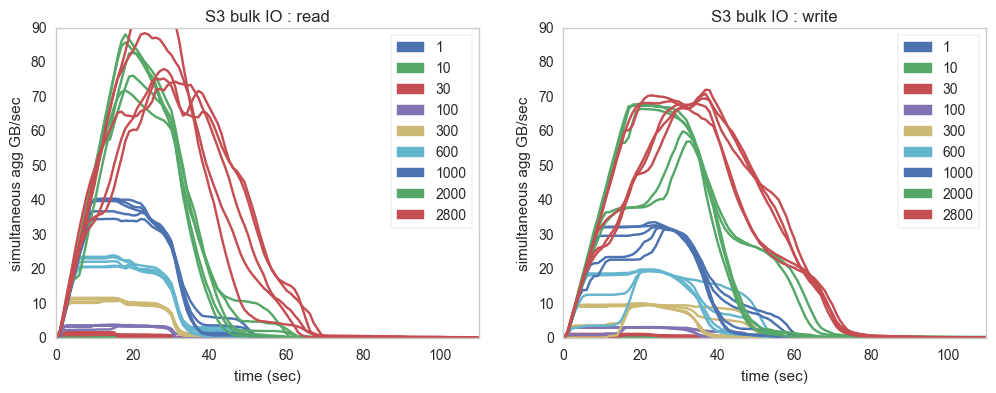

In [13]:

palette = sns.color_palette("deep", 20)
fig = pylab.figure(figsize=(12, 4))
peak_stats = []
for p_i, phase in enumerate(['read', 'write']):
    patches = []
    ax = fig.add_subplot(1, 2, 1 + p_i)
    for wi, (worker_count, d) in enumerate(expdf[expdf.mb_per_file==1000].groupby('workers')):
        for fname, df in d.groupby('filename'):
            agg_hist = filename_hists[phase][fname].sum(axis=0)/1e3
            ps = {'worker_count' : worker_count, 'filename' : fname, 'peak_GBs' : np.max(agg_hist), 
                 'phase' : phase}
            peak_stats.append(ps)
            ax.plot(runtime_bins, agg_hist, c=palette[wi])# , label=df.workers)
        patches.append(mpatches.Patch(color=palette[wi], label="{}".format(worker_count)))
    ax.set_xlim(0, 110)
    legend = pylab.legend(handles=patches, 
                          loc='upper right', frameon=True)
    #ax.set_yscale("log", nonposy='clip')
    ax.set_ylim(0, 90)
    ax.set_xlabel("time (sec)")
    ax.set_ylabel("simultaneous agg GB/sec")
    ax.set_title("S3 bulk IO : {}".format(phase))
    ax.grid(False)
fig.savefig("s3_scaling.simultaneous_vs_workers.png")


(0, 100)

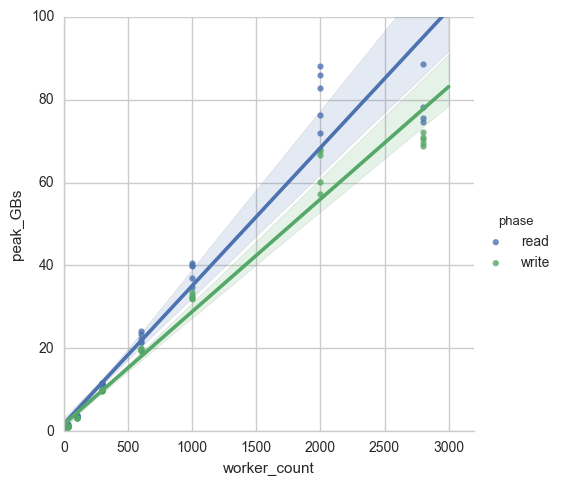

In [14]:
peak_df = pd.DataFrame(peak_stats)
sns.lmplot(x='worker_count', y='peak_GBs', data=peak_df, hue='phase')
pylab.xlim(0, 3200)
pylab.ylim(0, 100)

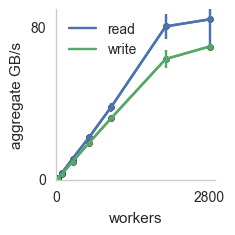

In [27]:
current_palette = sns.color_palette()
colors = {'read' : current_palette[0], 'write' : current_palette[1]}
s = peak_df.groupby(['worker_count', 'phase'])\
    .agg({'peak_GBs' : ['mean', 'std', 'min', 'max']}).reset_index()
fig = pylab.figure(figsize=(2.5, 2.5))
ax = fig.add_subplot(1, 1, 1)

for phase in ['read', 'write']:
    s2 = s[s.phase == phase]
    c = colors[phase]
    ax.plot(s2.worker_count, s2.peak_GBs['mean'], c=c, label=phase)
    ax.scatter(s2.worker_count, s2.peak_GBs['mean'], c=c, label=None)
    #ax.fill_between(s.index.values, s.peak_TFLOPS['min'], s.peak_TFLOPS['max'], color='b', alpha=0.2)
    ax.errorbar(s2.worker_count, np.array(s2.peak_GBs['mean']), 
                yerr=np.array(s2.peak_GBs['std']), c=c, label=None)
ax.grid(False)
ax.set_xlim(0, 2900)
ax.set_ylim(0, 90)
ax.set_xlabel('workers')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([0, 80])
ax.set_xticks([0, 2800])
ax.set_ylabel('aggregate GB/s')
ax.legend(loc='upper left')
fig.tight_layout()
fig.savefig("s3_scaling.s3_agg_tput.png")
#s.peak_TFLOPS['mean']

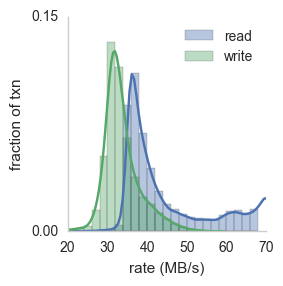

In [22]:
big_exp = expdf[expdf.workers == 2800]

txn_rate_df = job_results_df[['keyname', 's3_txn_rate', 'phase']]
a = pd.merge(big_exp, txn_rate_df, on='keyname')
fig = pylab.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1)
bins = np.linspace(20, 70, 25, endpoint=False)
for phase in ['read', 'write']:
    sns.distplot(a[a.phase == phase].s3_txn_rate, bins=bins, kde=True, kde_kws={"bw" : 1.0}, 
                 color=colors[phase], label=phase)
ax.grid(False)
ax.legend()
ax.set_xlim(20, 70)
#ax.set_ylim(0, 0.2)
ax.set_xlabel('rate (MB/s)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([0, .15])
ax.set_ylabel('fraction of txn')
fig.tight_layout()
fig.savefig("ms3_scaling.s3_txn_rate.png")

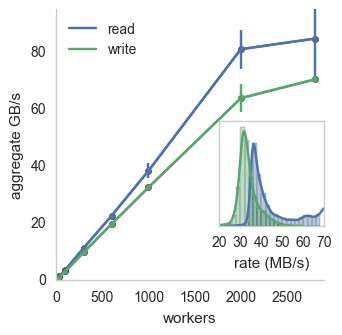

In [25]:
current_palette = sns.color_palette()
colors = {'read' : current_palette[0], 'write' : current_palette[1]}
s = peak_df.groupby(['worker_count', 'phase']).agg({'peak_GBs' : ['mean', 'std', 'min', 'max']}).reset_index()
fig = pylab.figure(figsize=(3.5, 3.5))
ax = fig.add_subplot(1, 1, 1)

for phase in ['read', 'write']:
    s2 = s[s.phase == phase]
    c = colors[phase]
    ax.plot(s2.worker_count, s2.peak_GBs['mean'], c=c, label=phase)
    ax.scatter(s2.worker_count, s2.peak_GBs['mean'], c=c, label=None)
    ax.errorbar(s2.worker_count, np.array(s2.peak_GBs['mean']), 
                yerr=np.array(s2.peak_GBs['std']), c=c, label=None)
ax.grid(False)
ax.set_xlim(0, 2900)
ax.set_ylim(0, 95)
ax.set_xlabel('workers')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([0, 20, 40, 60, 80])
ax.set_ylabel('aggregate GB/s')
ax.legend(loc='upper left')
fig.tight_layout()

#ax_insert = fig.add_axes([.3, .65, .3, .3])
ax_insert = fig.add_axes([.65, .33, .3, .3])

for phase in ['read', 'write']:
    sns.distplot(a[a.phase == phase].s3_txn_rate, bins=bins, kde=True, kde_kws={"bw" : 1.0}, 
                 color=colors[phase], label=phase)
ax_insert.grid(False)
#ax_insert.legend()
ax_insert.set_xlim(20, 70)
#ax.set_ylim(0, 0.2)
ax_insert.set_xlabel('rate (MB/s)')
#ax_insert.spines['top'].set_visible(False)
#ax_insert.spines['right'].set_visible(False)
ax_insert.set_yticks([]) # 0, .15])
ax_insert.set_ylabel('')


fig.savefig("s3_scaling.s3_agg_tput_combined.png")
#s.peak_TFLOPS['mean']